Импортируем модули.

In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

from matplotlib.ticker import AutoMinorLocator

%matplotlib inline

При обработке данных воспользуемся формулой, аналогичной формуле (10.35) из книжки Абрикосова при наличии только одного слагаемого в сумме по экстремальным сечениям $\sum_m$ (что логично, ибо в осцилляциях видна только одна частота):

$$
\frac{\tilde \rho_{xx}(B, T)}{\rho_{xx}(B=0, T)} \propto \sqrt B \frac{\lambda (B, T)}{\sinh \lambda (B, T)} e^{-\lambda_D(B)} \cos\left(2 \pi \frac{F}{B} +\varphi \right),
$$

где 
- $\tilde \rho_{xx}(B)$ - осциллирующая часть удельного сопротивления;
- $\omega_c$ - циклотронная частота;
- фактор, содержащий $\lambda (B, T)$, описывает температурную зависимость осцилляций;
- фактор Дингла $e^{-\lambda_D(B)}$ связан с рассеянием; 
- $F$ - частота осцилляций по обратному магнитному полю;
- $\varphi$ - фаза осцилляций. 

В системе СИ:
$$
\omega_c = \frac{e B}{m_c},\quad m_c = \frac{1}{2\pi}\frac{d S_p}{d \epsilon}, \quad \lambda(B, T) = 2 \pi ^2 \frac{k_B T}{\hbar \omega_c},\quad \lambda_D(B) = 2\pi^2 \frac{k_B T_D}{\hbar \omega_c}, \quad F = \frac{S_k}{2 \pi e},
$$
где
- $e$ - модуль заряда электрона;
- $m_c$ - циклотронная масса;
- $S_p$ - площадь экстремального сечения Ферми-поверхности в $p$-пространстве (выраженная в Дж $\cdot$ с / м).
- $k_B$ - постоянная Больцмана;
- $T_D = \frac{\hbar}{2\pi k_B \tau}$ - температура Дингла.

Для подгонки будем использовать пять параметров $C_0$, $C_1$, $C_2$, $F$, $\varphi$ вводимых согласно

$$
\lambda (B, T) = C_1 \frac{T}{B} = 2 \pi ^2 \frac{k_B T}{\hbar \omega_c} = 2 \pi ^2 \frac{m_c k_B T}{\hbar e B}\, \Longrightarrow\, C_1 = 2 \pi^2 \frac{m_c k_B}{e \hbar};
$$

$$
\lambda_D (B) = \frac{C_2}{B} = \frac{\pi}{\omega_c \tau} = \frac{\pi m_c}{e B \tau}\,\Longrightarrow\,C_2 = \frac{\pi m_c}{e \tau};
$$

$$
\frac{\tilde \rho_{xx}(B, T)}{\rho_{xx}(B=0, T)} = C_0 \frac{T}{\sqrt B} \frac{1}{\sinh \left(C_1 T/B\right)} e^{-C_2/B} \cos\left(2 \pi \frac{F}{B} +\varphi \right).
$$

In [2]:
#Usable constants

h = 6.65e-34 #Planck constant [J * s]
hbar = h / (2 * np.pi) #reduced Planck constant [J * s]
k_B = 1.38e-23 #Boltzmann constant
e = 1.6e-19 #Electron charge
pi = np.pi 

#Lifshitz-Kosevich formula (see explanation in the cell above)
def SdH_fit(T, B, C0, C1, C2, F, phi):
    '''
    INPUT: 
        T {float} - temperature [K]
        B {float} - magnetic flux density [T]
        C0 {float} - used to compensate other factors [...]
        C1 {float} - constant for taking temperature into account [T / K]
        C2 {float} - constant for taking Dingle factor into account [T]
        F {float} - oscillation frequency [T]
        phi {float} - oscillation phase [rad]
    OUTPUT:
        {float} - resulting resistance [dimless]
    '''
    return abs(C0) * (T / np.sqrt(B)) * (1 / (np.sinh(C1 * T / B))) * np.exp(-C2 / B) * np.cos(2 * pi * F / B + phi)

#amplitude of SdH oscillations from Lifshitz-Kosevich formula (for convinience)
def SdH_amp(T, B, C0, C1, C2):
    '''
    INPUT: 
        T {float} - temperature [K]
        B {float} - magnetic flux density [T]
        C0 {float} - used to compensate other factors [...]
        C1 {float} - constant for taking temperature into account [T / K]
        C2 {float} - constant for taking Dingle factor into account [T]
    OUTPUT:
        {float} - resulting resistance [dimless]
    '''
    return abs(C0) * T / (np.sqrt(B) * np.sinh(C1 * T / B)) * np.exp(-C2 / B)

Сначала исследуем температурную зависимость, чтобы определить значение циклотронной массы.

Загружаем графики.

In [4]:
folder_temp = r"var_T" #folder with files for different temperatures at theta = 0

temperatures = np.array([3.0, 6.0, 10.0, 15.0]) #angles of measurement
Data_temp = {} #dictionary with all data, angles act as keys

def parser(line): #function to parse datalines
    '''
    INPUT: 
        line {str} --- string with data, to be converted to floats
    OUTPUT: 
        res {list of floats} --- Angle, V_y, V_x, Temperature, Field
    '''
    split_line = line.split(',') #change decimal separator to dots and split line by tab symbols
    I = 5e-4 #current
    res = []
    for i in range(len(split_line)):
        if i in [13, 19]: #V_x and V_y
            res.append(float(split_line[i]) / I)
        if i in [2, 32, 38]: #Angle, Temperature, Field
            res.append(float(split_line[i]))
    return np.array(res)

for temp in temperatures:
    
    #open file and skip headers
    f = open(folder_temp + "\\T=" + str(temp) + '_theta=0.txt', 'r')
    f.readline()
    
    #create temporary data array and fill it with relevant data
    data = [] 
    
    while True:
        line = f.readline()
        if len(line) == 0:
            break
        data.append(parser(line))
        
    data = np.transpose(np.array(data)) #data is a (5 x N) np.array
    Data_temp[temp] = data
    
    #close file
    f.close()

Построим графики, и найдём первые (справа) 16 максимумов и минимумов и соответствующих им значений удельного сопротивления. Два параметра, а именно, частоту и фазу осцилляций можно приближённо определить на глаз: 
- частоту $F$ можно определить примерно по положениям максимумов: $F \approx 265$ T,
- фазу можно найти исходя из того, что для некоторого $B_0$ в максимуме фаза должна быть равна нулю $\varphi = -2\pi $ rad. 

local minima:
0 [0.08677514 2.42420366] 1.507030472695437e-31
1 [0.07420354 2.36751019] 1.4717864106202941e-31
2 [0.06332763 2.35923862] 1.4666443059696378e-31
3 [0.05447869 2.39552511] 1.4892021687024849e-31
4 [0.04642117 2.39651828] 1.4898195792431105e-31
5 [0.03939354 2.40296918] 1.4938298478069e-31
6 [0.03356584 2.38981862] 1.4856546736391455e-31
7 [0.02880194 2.3897662 ] 1.4856220814821064e-31
8 [0.02466552 2.40445758] 1.4947551279181246e-31
9 [0.0211854  2.35846586] 1.4661639158370872e-31
10 [0.01814976 2.35302143] 1.4627793281170699e-31
11 [0.01549359 2.25836715] 1.4039365503507882e-31
12 [0.0134913  2.29842976] 1.4288418693880643e-31
13 [0.01170631 2.23195762] 1.3875187969090355e-31
14 [0.00980782 2.04741803] 1.2727979142493665e-31
15 [0.00853112 2.1077167 ] 1.3102831903696469e-31

local maxima:
0 [0.00766521 2.7313115 ] 1.6979471407931903e-31
1 [0.00783427 2.33896415] 1.454040480847986e-31
2 [0.0096325  2.39259006] 1.487377562321157e-31
3 [0.01157688 2.39530663] 1.489066347302

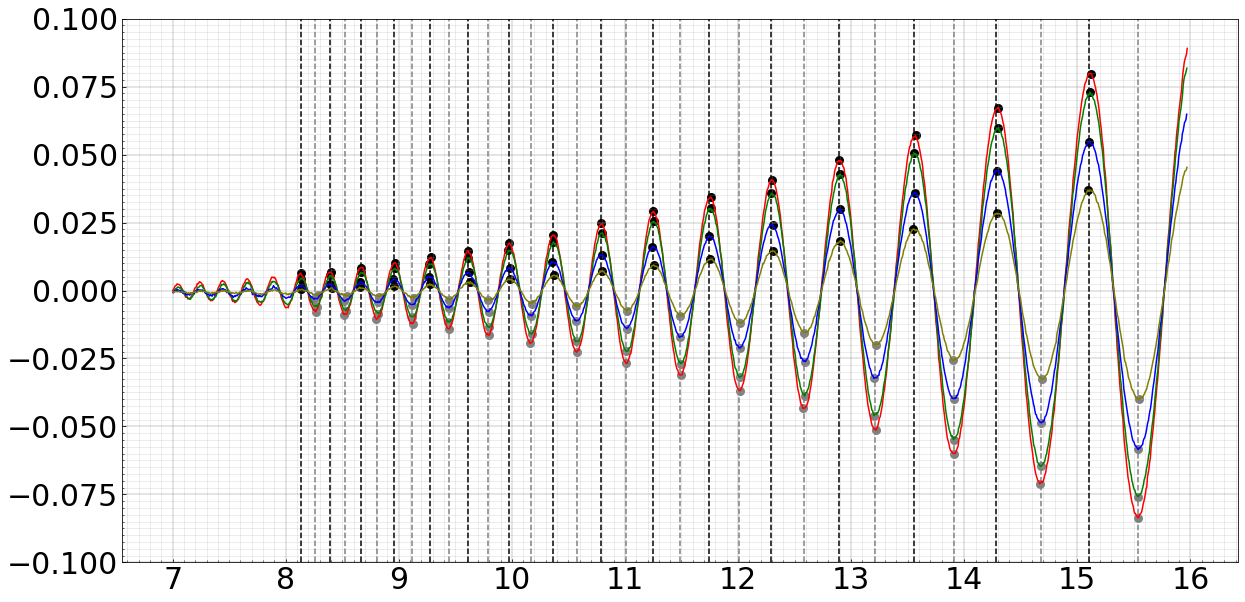

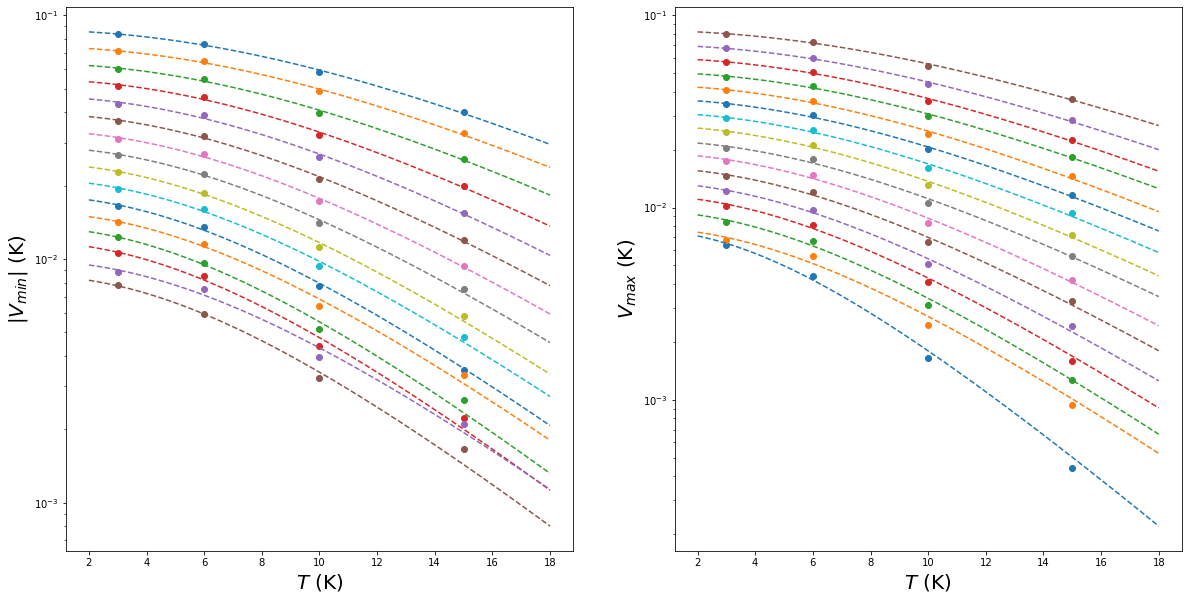

In [5]:
#define some fitting functions

def Extr_B(B0, F, n): #extremal value of B, based on a known value of 0-th extremal value 
    '''
    INPUT: 
        B0 {float} - known 0-th extremal value [K]
        F {float} - oscillation frequency [T]
        n {int} - number of extrema relative to B0 [dimless]
    OUTPUT:
        B_n {float} - n-th extremal value [T]
    '''
    return B0 / (1 + n * B0 / F) 

def psi(T, B, a, b): #fitting function for analyzing temperature dependance of the oscillations
    '''
    INPUT: 
        T {float} - Temperature [K]
        B {float} - magnetic flux density [T]
        a {float} - general amplitude [dimless]
        b {float} - fitting parameter (equal to C1 = 2 pi^2 m_c k_B / hbar * e) [T / K]
    OUTPUT:
        psi {float} - resulting value [dimless]
    '''
    return a * b * (T / B) / np.sinh(b * T / B)

###############################################################################################################
###############################################################################################################

fig = plt.figure(figsize=(20, 10)) #create figure
ax = plt.subplot(111) #organize axis

colors={ #colors for plots
    3.0: 'red',
    6.0: 'green',
    10.0: 'blue',
    15.0: 'olive'
}

#initial values for B maxima and minima 
B0_max = 15.1
B0_min = 15.54

#optimal oscillation frequency
F = 264.52070603

#extremal values - initial guess
n_arr = range(0, 16)
B0_max_arr = Extr_B(B0_max, F, np.array(n_arr))
B0_min_arr = Extr_B(B0_min, F, np.array(n_arr))

#add initial guess vertical dotted lines to plot
for B0 in B0_max_arr:
    plt.axvline(x=B0, ls='--', c='black')
for B0 in B0_min_arr:
    plt.axvline(x=B0, ls='--', c='grey')
    
#data storage of extremal fields and corresponding resistivities
Min_data = {temperatures[i]: np.empty([2, 16]) for i in range(4)}
Max_data = {temperatures[i]: np.empty([2, 16]) for i in range(4)}
    
#main cycle
for key in Data_temp.keys():

    #shorter names for data
    Vy = Data_temp[key][1]
    Vx = Data_temp[key][2]
    B = Data_temp[key][4]
    
    #sort by B
    sort_index = np.argsort(B)
    B = B[sort_index]
    Vx = Vx[sort_index]
    Vy = Vy[sort_index]
    
    #interpolation
    int_len = 5000 #number of points in grid
    b_max = min(max(B), abs(min(B)))
    B_int = np.linspace(-b_max, b_max, int_len)
    Vx_int = np.interp(B_int, B, Vx)
    Vy_int = np.interp(B_int, B, Vy)
    
    #symmetrization
    Vx_sym = 0.5 * (Vx_int + Vx_int[::-1])
    Vy_asm = 0.5 * (Vy_int - Vy_int[::-1])
    
    B_sym = B_int[B_int > 0]
    Vx_sym = Vx_sym[B_int > 0]
    Vy_asm = Vy_asm[B_int > 0]
    
    #remove background by fitting with fifth degree polynomial
    p = np.poly1d(np.polyfit(B_sym, Vx_sym, 5))
    Vx_bg = (Vx_sym - p(B_sym)) / p(0)
    
    #leave only B for fitting (B > 7 T should be enough for all angles and temperatures)
    B_fit = B_sym[B_sym > 7]
    Vx_fit = Vx_bg[B_sym > 7]
        
    plt.plot(B_fit, Vx_fit, label=r'$T = %.1f$ K' % key, c=colors[key])
    
    #finding all local minima
    B2 = 16 #initial upper bound
    for n in n_arr:
        B1 = B0_max_arr[n] #set lower bound
        
        #restrict B to (B1, B2)
        B_fit_restr = B_fit[(B_fit > B1) & (B_fit < B2)]
        Vx_fit_restr = Vx_fit[(B_fit > B1) & (B_fit < B2)]
        
        #find B_min, Vx_min through argmin
        ind_min = np.argmin(Vx_fit_restr)
        B_min = B_fit_restr[ind_min]
        Vx_min = Vx_fit_restr[ind_min]
        
        #set data values
        Min_data[key][0, n] = B_min
        Min_data[key][1, n] = Vx_min
        
        B2 = B1 #set upper bound to previous lower bound
        
    #finding all local maxima
    B1 = 8 #initial lower bound
    for n in n_arr:
        B2 = B0_min_arr[-n-1] #set upper bound
        
        #restrict B to (B1, B2)
        B_fit_restr = B_fit[(B_fit > B1) & (B_fit < B2)]
        Vx_fit_restr = Vx_fit[(B_fit > B1) & (B_fit < B2)]
        
        #find B_max, Vx_max through argmax
        ind_max = np.argmax(Vx_fit_restr)
        B_max = B_fit_restr[ind_max]
        Vx_max = Vx_fit_restr[ind_max]
        
        #set data values
        Max_data[key][0, n] = B_max
        Max_data[key][1, n] = Vx_max
        
        B1 = B2 #set lower bound to previous upper bound
        
    #scatter max and min points
    plt.scatter(Min_data[key][0], Min_data[key][1], c='grey', lw=3)
    plt.scatter(Max_data[key][0], Max_data[key][1], c='black', lw=3)

###############################################################################################################
    
#set graph
x_minor_locator = AutoMinorLocator(10)
ax.xaxis.set_minor_locator(x_minor_locator)
y_minor_locator = AutoMinorLocator(10)
ax.yaxis.set_minor_locator(y_minor_locator)

plt.tick_params(axis='both', which='major', direction='in', labelsize=30)
plt.tick_params(axis='both', which='minor', direction='in', labelsize=8)
plt.grid(b=True, which='major', color='0.65', linestyle='-', lw=2, alpha=0.3)
plt.grid(b=True, which='minor', color='0.65', linestyle='-', lw=0.7, alpha=0.3)

ax.set_ylim(-0.1, 0.1)
ax.set_xticks(np.arange(7, 16.1, 1))

plt.legend(loc='best', fontsize=25)

###############################################################################################################
# inteprolation of local maxima and local minima with z / sh(z) function
###############################################################################################################

#second figure 
fig2 = plt.figure(figsize=(20, 10))

#organize axis 1
ax1 = plt.subplot(121)
ax1.set_xlabel(r"$T$ (K)", fontsize=20)
ax1.set_ylabel(r"$|V_{min}|$ (K)", fontsize=20)

#organize axis 2
ax2 = plt.subplot(122)
ax2.set_xlabel(r"$T$ (K)", fontsize=20)
ax2.set_ylabel(r"$V_{max}$ (K)", fontsize=20)

print("local minima:")
#plot local minima vs temperature
for n in n_arr:
    #get data values
    values = np.array([abs(Min_data[key][1, n]) for key in Min_data.keys()]) 
    
    #scatter local minima
    ax1.scatter(temperatures, values, marker='o')
    
    #find best fitting parametres
    p0 = [0.1, 1]
    popt, _ = curve_fit(lambda T, a, b: psi(T, Min_data[key][0, n], a, b), temperatures, values, p0=p0, bounds=(0, +np.inf))
    
    #plot best fit
    temps_int = np.linspace(2, 18, 100)
    ax1.plot(temps_int, psi(temps_int, Min_data[key][0, n], *popt), ls='--')
    ax1.set_yscale('log')
    
    m_c = hbar * e * popt[1] / (2 * k_B * np.pi**2) #determine cyclotrone mass
    
    print(n, popt, m_c)

print("\nlocal maxima:")
#plot local maxima vs temperature
for n in n_arr:
    #get data values
    values = np.array([abs(Max_data[key][1, n]) for key in Max_data.keys()])
    
    #scatter local maxima
    ax2.scatter(temperatures, values, marker='o')
    
    #find best fitting parametres
    p0 = [0.1, 1]
    popt, _ = curve_fit(lambda T, a, b: psi(T, Max_data[key][0, n], a, b), temperatures, values, p0=p0, bounds=(0, +np.inf))

    #plot best fit
    temps_int = np.linspace(2, 18, 100)
    ax2.plot(temps_int, psi(temps_int, Max_data[key][0, n], *popt), ls='--')
    ax2.set_yscale('log')

    m_c = hbar * e * popt[1] / (2 * k_B * np.pi**2) #determine cyclotrone mass
    
    print(n, popt, m_c)

Делаем вывод, что оптимальное значение циклотронной массы для угла наклона поля к оси $c$, близкого к нулю, составляет примерно $1.5\cdot 10^{-31}$ кг, а оптимальное значение постоянной $C_1$ - примерно $2.3$ T / K. 

Теперь построим графики угловой зависимости.

In [6]:
folder_theta = r"var_theta" #folder with files for different angles at T = 3
folder_T = r"var_T" #folder with files for different temperatures at theta = 0

angles = np.array([0, 22.3, 32, 39.2, 47, 56.5]) #angles of measurement
Data = {} #dictionary with all data, angles act as keys

for theta in angles:
    
    #open file and skip headers
    f = open(folder_theta + "\\T=3_theta=" + str(theta) + '.txt', 'r')
    f.readline()
    
    #create temporary data array and fill it with relevant data
    data = [] 
    
    while True:
        line = f.readline()
        if len(line) == 0:
            break
        data.append(parser(line))
        
    data = np.transpose(np.array(data)) #data is a (5 x N) np.array
    Data[theta] = data
    
    #close file
    f.close()

theta = 0.0 (deg),	F = 264.5 (T),	phi = 6.16 (T),	A_k = 2.51e+18 (m^(-2))
theta = 22.3 (deg),	F = 289.1 (T),	phi = 2.79 (T),	A_k = 2.75e+18 (m^(-2))
theta = 32.0 (deg),	F = 316.8 (T),	phi = 2.39 (T),	A_k = 3.01e+18 (m^(-2))
theta = 39.2 (deg),	F = 345.9 (T),	phi = 2.34 (T),	A_k = 3.29e+18 (m^(-2))
theta = 47.0 (deg),	F = 403.5 (T),	phi = 3.05 (T),	A_k = 3.83e+18 (m^(-2))


<ipython-input-2-7f0456a9469e>:23: RuntimeWarning: overflow encountered in sinh
  return abs(C0) * (T / np.sqrt(B)) * (1 / (np.sinh(C1 * T / B))) * np.exp(-C2 / B) * np.cos(2 * pi * F / B + phi)


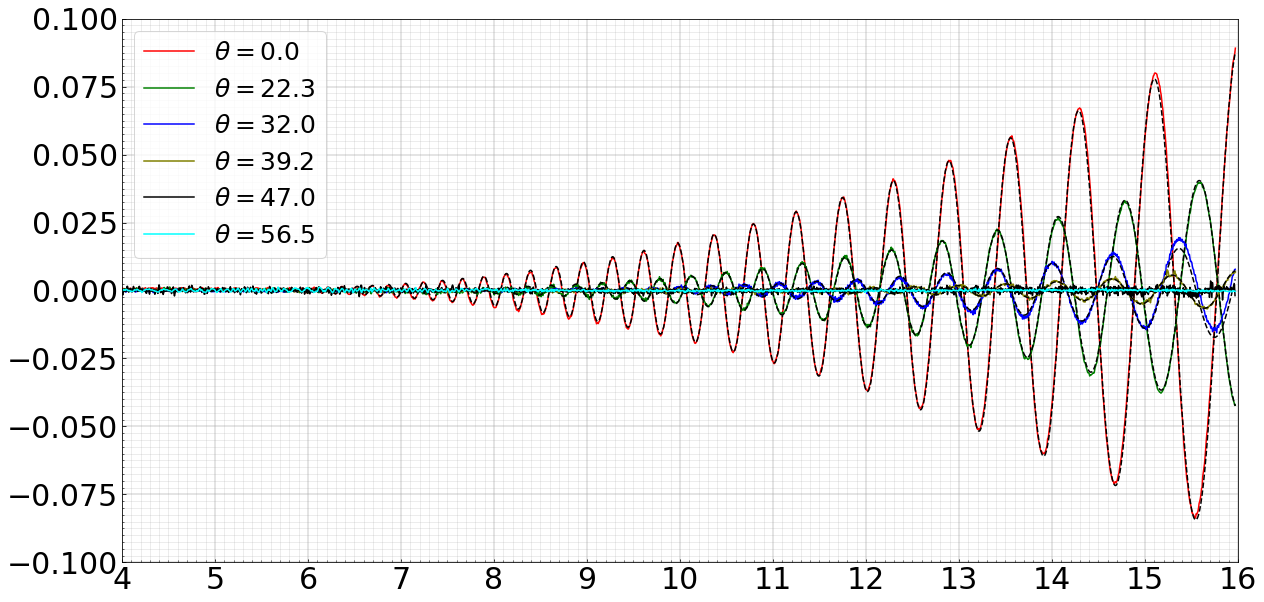

In [41]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)


#dictionary with initial parametres
p0 = {    #C0, C1, C2, F, phi
    0.0: np.array([1, 1, 30, 250, 0]), #perfect fit
    22.3: np.array([1, 0.1, 10, 250, 0]), #
    32.0: np.array([1, 1, 30, 250, 0]), #good
    39.2: np.array([1, 1, 30, 250, 0]), #good
    47.0: np.array([1, 1, 30, 250, 0]),
    56.5: np.array([1, 1, 30, 250, 0])
}

p_opt = {angles[i]: np.empty([5]) for i in range(6)}
C_opt = {angles[i]: np.empty([1]) for i in range(6)}

colors_theta = { #colors for plots
    0.0: 'red',
    22.3: 'green',
    32.0: 'blue',
    39.2: 'olive',
    47.0: 'black',
    56.5: 'cyan'
}

#set graph
x_minor_locator = AutoMinorLocator(10)
ax.xaxis.set_minor_locator(x_minor_locator)
y_minor_locator = AutoMinorLocator(10)
ax.yaxis.set_minor_locator(y_minor_locator)

plt.tick_params(axis='both', which='major', direction='in', labelsize=30)
plt.tick_params(axis='both', which='minor', direction='in', labelsize=8)
plt.grid(b=True, which='major', color='0.65', linestyle='-', lw=2, alpha=0.3)
plt.grid(b=True, which='minor', color='0.65', linestyle='-', lw=0.7, alpha=0.3)

ax.set_ylim(-0.1, 0.1)
ax.set_xticks(np.arange(4, 16.1, 1))

for key in Data.keys():
#     if key not in [0, 22.3, 32, 39.2, 47, 56.5]: #22.3, 32, 39.2, 47, 56.5
#         continue
    #shorter names for data
    Vy = Data[key][1]
    Vx = Data[key][2]
    B = Data[key][4]
    
    #sort by B
    sort_index = np.argsort(B)
    B = B[sort_index]
    Vx = Vx[sort_index]
    Vy = Vy[sort_index]
    
    #interpolation
    int_len = 5000 #number of points in grid
    b_max = min(max(B), abs(min(B)))
    B_int = np.linspace(-b_max, b_max, int_len)
    Vx_int = np.interp(B_int, B, Vx)
    Vy_int = np.interp(B_int, B, Vy)
    
    #symmetrization
    Vx_sym = 0.5 * (Vx_int + Vx_int[::-1])
    Vy_asm = 0.5 * (Vy_int - Vy_int[::-1])
    
    B_sym = B_int[B_int > 0]
    Vx_sym = Vx_sym[B_int > 0]
    Vy_asm = Vy_asm[B_int > 0]
    
    #remove background by fitting with fifth degree polynomial
    p = np.poly1d(np.polyfit(B_sym, Vx_sym, 5))
    Vx_bg = (Vx_sym - p(B_sym)) / p(0)
#     Vx_bg = Vx_sym
    
    #leave only B for fitting (B > 4 T should be enough for all angles and temperatures)
    B_fit = B_sym[B_sym > 4]
    Vx_fit = Vx_bg[B_sym > 4]
    
    plt.plot(B_fit, Vx_fit, label=r'$\theta = %.1f$' % key, color=colors_theta[key])
    
    if key != 56.5:
        #find fit parametres
        popt, pcov = curve_fit(lambda B, C0, C1, C2, F, phi: SdH_fit(3, B, C0, C1, C2, F, phi), B_fit, Vx_fit, p0=p0[key])
        p_opt[key] = popt
        plt.plot(B_fit, SdH_fit(3, B_fit, *popt), color='k', ls='--')
        
        A_k = 2 * np.pi * e * popt[3] / hbar #Fermi-surface extreme cross-section (in terms of k, not p) [1/m^2] 
        C_opt[key][0] = A_k
    
for key in p_opt:
    if key != 56.5:
        print("theta = %.1f (deg),\tF = %.1f (T),\tphi = %.2f (T),\tA_k = %.2e (m^(-2))" % 
              (key, p_opt[key][3], (p_opt[key][4] % (2 * np.pi)), C_opt[key][0]))
#     print(p_opt[key])

plt.xlim(4, 16)
plt.legend(loc='best', fontsize=25)
    
#     A_k = 2 * np.pi * e * popt[3] / hbar #Fermi-surface extreme cross-section (in terms of k, not p) [1/m^2] 
#     k_F = np.sqrt(A_k / np.pi) #Fermi wavenumber [1 / m]
#     p_F = hbar * k_F #Fermi momentum [kg / (m * s)]
#     m_c = e * hbar * abs(popt[1]) / (2 * np.pi**2 * k_B) #cyclotrone mass (equal to effective mass for now) [kg]
#     E_F = p_F**2 / (2 * m_c) #Fermi energy [J]
#     tau = np.pi * m_c / (popt[2] * e) #Relaxation time [s]
#     mu = e * tau / m_c #mobility [m^2 / (V * s)]
#     n = e / (F * h) #concentration (assuming K = 1) [1 / m^3]
    
#     Parametres[key] = np.array([A_k, k_F, p_F, m_c, E_F, tau, mu, n])

#     print('''Angle %.1f\n\tFermi-surface cross-section area %.2e (1/m)^2\n''' % (key, A_k))
#     print('''Angle %.1f\n\tFermi-surface cross-section area %.2e (1/m)^2\n Fermi wavenumber %.2e (1/m)\n\teffective mass %.2e (kg)\n\tFermi energy %.2e (eV) \
#     \n\tRelaxation time %.2e (s)\n\tMobility %.2e (cm^2 / V * S)\n\tConcentration %.2e (1 / cm^3)\n''' 
#       % (key, k_F, m_c, E_F / (k_B * 11600), tau, 1e4 * mu, n) + ('-' * 100))

# A_k_arr = np.array([Parametres[key][0] for key in Parametres.keys()]) 
# m_c_arr = np.array([Parametres[key][3] for key in Parametres.keys()]) 

# def A_p1(theta, a, eps, theta_0):
#     return a / np.sqrt(1 - eps**2 * np.sin(np.pi * (theta - theta_0) / 180)**2)

# popt1, _ = curve_fit(A_p1, angles[:4], A_k_arr[:4], p0=[2.5e18, 1, 0], bounds=([2e18, 0.01, -180], [4e18, 2, 180]))
# print(popt1)

# plt.figure()

# ax1 = plt.subplot(111)
# ax2 = ax1.twinx()
# ax1.scatter(angles[:4], A_k_arr[:4])
# Theta = np.linspace(0, 40, 50)
# ax1.plot(Theta, A_p1(Theta, *popt1))
# ax2.scatter(angles[:5], m_c_arr[:5], color='red')
# # plt.plot(Theta, A_p2(Theta, *popt2))

Будем пользоваться формулой
$$
V(B, T) - V(0, T) \propto \sqrt\frac{\hbar \omega_c}{2 \varepsilon_F}\frac{\lambda (B, T)}{\sinh \lambda (B, T)} e^{-\lambda_D(B)} \cos\left(2 \pi \frac{F}{B} +\varphi \right),
$$
где $\epsilon_F$ - энергия Ферми, $\omega_c$ - циклотронная частота; фактор с $\lambda (B, T)$ описывает температурную зависимость, а фактор Дингла $\lambda_D(B)$ связан с рассеянием; $F$ - частота осцилляций по обратному магнитному полю, $\varphi$ - фаза осцилляций. В системе СИ:
$$
\omega_c = \frac{e B}{m_c},\quad m_c = \frac{\hbar^2}{2\pi}\frac{d A_k}{d \epsilon},
$$

$$
\lambda (B, T) = C_1 \frac{T}{B} = 2 \pi ^2 \frac{k_B T}{\hbar \omega_c} = 2 \pi ^2 \frac{m_c k_B T}{\hbar e B}\, \Longrightarrow\, C_1 = 2 \pi^2 \frac{m_c k_B}{e \hbar}\,\Longrightarrow\,m_c = \frac{1}{2 \pi^2}\frac{e \hbar}{k_B} C_1
$$

$$
\lambda_D (B) = \frac{C_2}{B} = \frac{\pi}{\omega_c \tau} = \frac{\pi m_c}{e B \tau}\,\Longrightarrow\,C_2 = \frac{\pi m_c}{e \tau}\,\Longrightarrow\,\tau = \frac{\pi m_c}{C_2 e}
$$

Фактор заполнения по магнитному полю:
$$
\nu = K \cdot \frac{n S}{N_L} = K n \frac{2 \pi \hbar}{e B}, 
$$
поэтому период осцилляций по обратному магнитному полю 
$$
T = \frac{1}{F} = K n \frac{h}{e}\,\Longrightarrow\,n = \frac{1}{K}\frac{e}{F h}
$$

[  1.34820188  11.98454012  13.80209215 264.52631159   3.01566744]
[6.90388665e-03 1.34517940e+02 4.75141807e+01 2.69962830e+02
 3.12725929e+00]
[3.18019220e-03 1.31959200e+02 4.44065379e+01 2.69971262e+02
 3.13443822e+00]
[4.98293467e-02 3.64752865e+01 1.31167568e+02 2.68905437e+02
 2.44834880e+00]


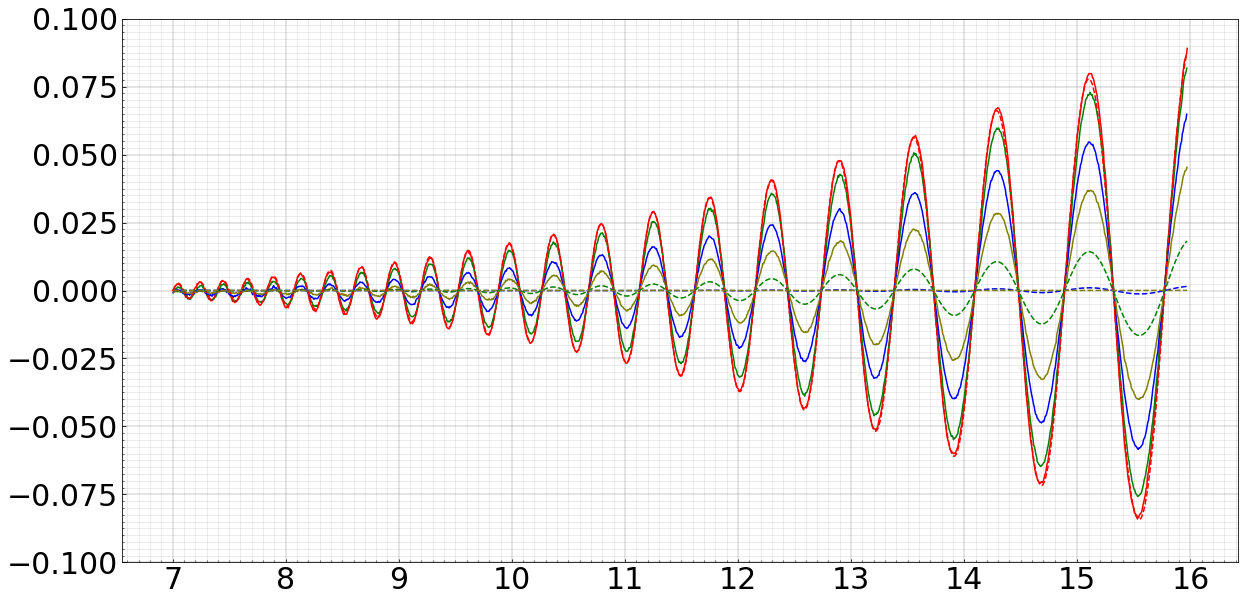

In [244]:
#dictionary with initial parametres
p0_temp = { #C0, C1, C2, F, phi
    3.0: np.array([1, 1, 30, 265, 0]), #good
    6.0: np.array([0.1, 2.3, 15, 265, 0]), #good
    10.0: np.array([0.1, 2.3, 15, 265, 0]), #good
    15.0: np.array([0.05, 2.3, 15, 265, 0]) #good
}

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

#set graph
x_minor_locator = AutoMinorLocator(10)
ax.xaxis.set_minor_locator(x_minor_locator)
y_minor_locator = AutoMinorLocator(10)
ax.yaxis.set_minor_locator(y_minor_locator)

plt.tick_params(axis='both', which='major', direction='in', labelsize=30)
plt.tick_params(axis='both', which='minor', direction='in', labelsize=8)
plt.grid(b=True, which='major', color='0.65', linestyle='-', lw=2, alpha=0.3)
plt.grid(b=True, which='minor', color='0.65', linestyle='-', lw=0.7, alpha=0.3)

ax.set_ylim(-0.1, 0.1)
ax.set_xticks(np.arange(7, 16.1, 1))

#main cycle
for key in p0_temp.keys():
    
    #shorter names for data
    Vy = Data_temp[key][1]
    Vx = Data_temp[key][2]
    B = Data_temp[key][4]
    
    #sort by B
    sort_index = np.argsort(B)
    B = B[sort_index]
    Vx = Vx[sort_index]
    Vy = Vy[sort_index]
    
    #interpolation
    int_len = 5000 #number of points in grid
    b_max = min(max(B), abs(min(B)))
    B_int = np.linspace(-b_max, b_max, int_len)
    Vx_int = np.interp(B_int, B, Vx)
    Vy_int = np.interp(B_int, B, Vy)
    
    #symmetrization
    Vx_sym = 0.5 * (Vx_int + Vx_int[::-1])
    Vy_asm = 0.5 * (Vy_int - Vy_int[::-1])
    
    B_sym = B_int[B_int > 0]
    Vx_sym = Vx_sym[B_int > 0]
    Vy_asm = Vy_asm[B_int > 0]
    
    #remove background by fitting with fifth degree polynomial
    p = np.poly1d(np.polyfit(B_sym, Vx_sym, 5))
    Vx_bg = (Vx_sym - p(B_sym)) / p(0)
    
    #leave only B for fitting (B > 7 T should be enough for all angles and temperatures)
    B_fit = B_sym[B_sym > 7]
    Vx_fit = Vx_bg[B_sym > 7]
        
    plt.plot(B_fit, Vx_fit, label='%.1f' % key, c=colors[key])
    
    #find fit parametres
    popt, _ = curve_fit(lambda B, C0, C1, C2, F, phi: SdH_fit(key, B, C0, C1, C2, F, phi), B_fit, Vx_fit, p0=p0_temp[key],
                       maxfev=10000, bounds=([0, 0, 0, 260, -np.pi], [np.inf, np.inf, np.inf, 270, np.pi]))
    
#     plt.plot(B_fit, SdH_fit(key, B_fit, *popt), ls='--', color=colors[key])
    
    print(popt)
    
p_guess = [1.34820188,  11.98454012,  13.80209215,  264.52631159, 3.01566744]
    
for temp in temperatures:
    plt.plot(B_fit, SdH_fit(temp, B_fit, *p_guess), ls='--', color=colors[temp])
    
#     F_opt = 264.52631465
#     phi_opt = 3.01566605
#     C1_opt = 2.5
    
#     popt, _ = curve_fit(lambda B, C0, C2: SdH_fit(key, B, C0, C1_opt, C2, F_opt, phi_opt), B_fit, Vx_fit, 
#                         p0=np.array([0.1, 10]), maxfev=10000, bounds=([0, 0], [np.inf, np.inf]))
    
# #     plt.plot(B_fit, SdH_fit(key, B_fit, *popt), ls='--', color=colors[key])
#     p_guess = [0.1, 210]
#     plt.plot(B_fit, SdH_fit(key, B_fit, *p_guess, F=F_opt, phi=phi_opt), ls='--', color='black')
# #     plt.plot(B_fit, SdH_amp(key, B_fit, *p_guess), ls='--', color='black')
# #     plt.plot(B_fit, -SdH_amp(key, B_fit, *p_guess), ls='--', color='black')

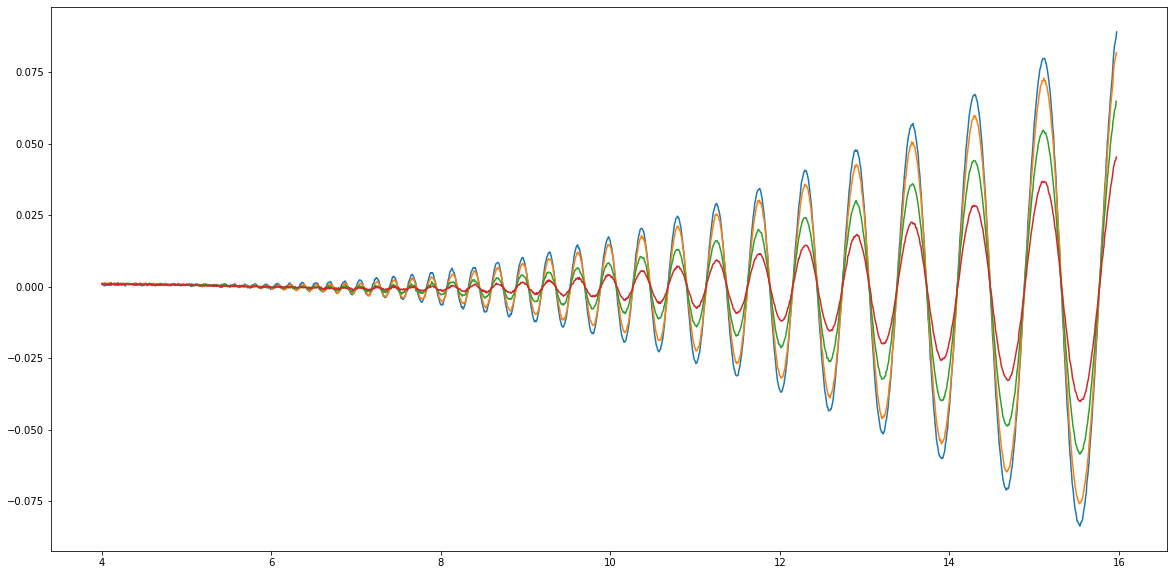

In [63]:
folder_T = r"var_T" #folder with files for different temperatures at theta = 0

temperatures = np.array([3.0, 6.0, 10.0, 15.0]) #angles of measurement
Data1 = {} #dictionary with all data, angles act as keys

for temp in temperatures:
    
    #open file and skip headers
    f = open(folder_T + "\\T=" + str(temp) + '_theta=0.txt', 'r')
    f.readline()
    
    #create temporary data array and fill it with relevant data
    data = [] 
    
    while True:
        line = f.readline()
        if len(line) == 0:
            break
        data.append(parser(line))
        
    data = np.transpose(np.array(data)) #data is a (5 x N) np.array
    Data1[temp] = data
    
    #close file
    f.close()
    
fig = plt.figure(figsize=(20, 10))

#dictionary with initial parametres
p01 = { #C0, C1, C2, F, phi
    3.0: np.array([1.3569061, 12.60925442, 11.99651544, 264.52070603, 3.01814082]), #good
    6.0: np.array([0.1, 1, 15, 250, 0]), #good
    10.0: np.array([0.1, 1, 15, 250, 0]), #good
    15.0: np.array([0.05, 1, 15, 250, 0]) #good
}

Parametres1 = {}

for key in Data1.keys():
#     if key != 3:
#         continue
    #shorter names for data
    Vy = Data1[key][1]
    Vx = Data1[key][2]
    B = Data1[key][4]
    
    #sort by B
    sort_index = np.argsort(B)
    B = B[sort_index]
    Vx = Vx[sort_index]
    Vy = Vy[sort_index]
    
    #interpolation
    int_len = 5000 #number of points in grid
    b_max = min(max(B), abs(min(B)))
    B_int = np.linspace(-b_max, b_max, int_len)
    Vx_int = np.interp(B_int, B, Vx)
    Vy_int = np.interp(B_int, B, Vy)
    
    #symmetrization
    Vx_sym = 0.5 * (Vx_int + Vx_int[::-1])
    Vy_asm = 0.5 * (Vy_int - Vy_int[::-1])
    
    B_sym = B_int[B_int > 0]
    Vx_sym = Vx_sym[B_int > 0]
    Vy_asm = Vy_asm[B_int > 0]
    
    #remove background by fitting with fifth degree polynomial
    p = np.poly1d(np.polyfit(B_sym, Vx_sym, 5))
    Vx_bg = (Vx_sym - p(B_sym)) / p(0)
    
    #leave only B for fitting (B > 4 T should be enough for all angles and temperatures)
    B_fit = B_sym[B_sym > 4]
    Vx_fit = Vx_bg[B_sym > 4]
    
#     #find fit parametres
#     popt, pcov = curve_fit(lambda B, C0, C1, C2, F, phi: SdH_fit(key, B, C0, C1, C2, F, phi), 
#                            B_fit, Vx_fit, p0=p01[key], maxfev=10000,  bounds=(0, +np.inf))
    
#     print(popt)
    
#     Vx_best_fit = SdH_fit(key, B_sym, *popt)
#     Vx_init_guess = SdH_fit(key, B_sym, *p01[key])
#     Vx_amp_fit = SdH_amp(key, B_sym, *popt[:-2])
    
    plt.plot(B_fit, Vx_fit, label='%.1f' % key)
#     plt.plot(B_sym, Vx_init_guess, alpha=0.5)
#     plt.plot(B_sym, Vx_best_fit, ls='--', color='k')
#     plt.plot(B_sym, Vx_amp_fit, ls='--', c='grey')
#     plt.plot(B_sym, -Vx_amp_fit, ls='--', c='grey')

# for key in Data1.keys():
#     Vx_init_guess = SdH_fit(key, B_sym, *p01[key])
#     Vx_amp_fit = SdH_amp(key, B_sym, *popt[:-2])
    
#     plt.plot(B_sym, Vx_init_guess, ls='--', c='k')
    
#     A_k = 2 * np.pi * e * popt[3] / hbar #Fermi-surface extreme cross-section (in terms of k, not p) [1/m^2] 
#     k_F = np.sqrt(A_k / np.pi) #Fermi wavenumber [1 / m]
#     p_F = hbar * k_F #Fermi momentum [kg / (m * s)]
#     m_c = e * hbar * abs(popt[1]) / (2 * np.pi**2 * k_B) #cyclotrone mass (equal to effective mass for now) [kg]
#     E_F = p_F**2 / (2 * m_c) #Fermi energy [J]
#     tau = np.pi * m_c / (popt[2] * e) #Relaxation time [s]
#     mu = e * tau / m_c #mobility [m^2 / (V * s)]
#     n = e / (F * h) #concentration (assuming K = 1) [1 / m^3]
    
#     Parametres1[key] = np.array([A_k, k_F, p_F, m_c, E_F, tau, mu, n])

#     print('''Temperature %.1f (K)\n\tFermi wavenumber %.2e (1/m)\n\teffective mass %.2e (kg)\n\tFermi energy %.2e (eV) \
#     \n\tRelaxation time %.2e (s)\n\tMobility %.2e (cm^2 / V * S)\n\tConcentration %.2e (1 / cm^3)\n''' 
#       % (key, k_F, m_c, E_F / (k_B * 11600), tau, 1e4 * mu, n) + ('-' * 100))
    
# plt.plot(B_fit, SdH_fit(B_fit, 0.033, -3.64458789e+01, -4.84931489e+01,  2.64650677e+02,
#  -3.32479436e+00), lw=4)

[ 1.16503324e-01  1.11542058e+01  1.57637608e+01  2.64535528e+02
 -3.29488438e+00]
Fermi wavenumber 8.94e+08 (1/m)
effective mass 6.93e-31 (kg)
Fermi energy 4.04e-02 (eV) 
Relaxation time 8.64e-13 (s)
Mobility 1.99e+03 (cm^2 / V * S)
Concentration 9.62e+11 (1 / cm^3)


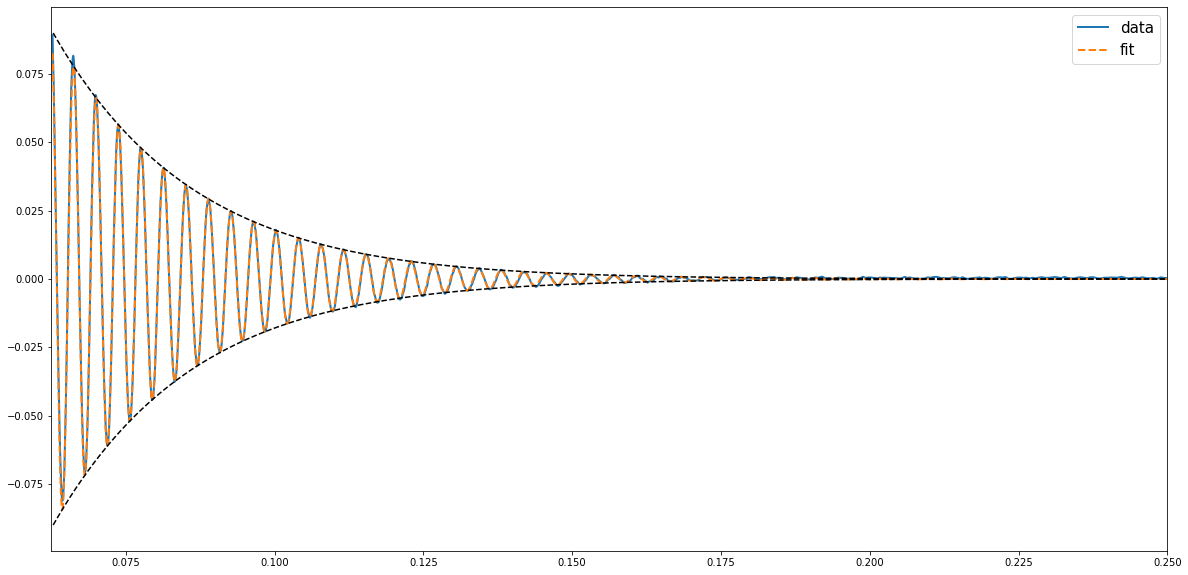

In [183]:
# #Constants
# h = 6.65e-34 #Planck constant [J * s]
# hbar = h / (2 * np.pi) #reduced Planck constant [J * s]
# k_B = 1.38e-23 #Boltzmann constant
# e = 1.6e-19 #Electron charge

# T = 3

# def SdH_fit(B, C0, C1, C2, F, phi):
#     return abs(C0) * np.sqrt(B) * C1 * T / (B * np.sinh(C1 * T / B)) * np.exp(-C2 / B) * np.cos(2 * np.pi * F / B + phi)

# def SdH_amp(B, C0, C1, C2):
#     return abs(C0) * np.sqrt(B) * C1 * T / (B * np.sinh(C1 * T / B)) * np.exp(-C2 / B)

# B_fit = np.linspace(0.5, 16, 1000)
# C0 = 1
# C1 = 1 
# C2 = 30
# F = 250
# phi = 0

# p0 = [C0, C1, C2, F, phi]
# popt, pcov = curve_fit(SdH_fit, B[B > 4], Vx_bg[B > 4], p0=p0)

# print(popt)

# A_k = 2 * np.pi * e * popt[3] / hbar #Fermi-surface extreme cross-section (in terms of k, not p) [1/m^2] 
# k_F = np.sqrt(A_k / np.pi) #Fermi wavenumber [1 / m]
# p_F = hbar * k_F #Fermi momentum [kg / (m * s)]
# m_c = e * hbar * popt[1] / (2 * np.pi**2 * k_B) #cyclotrone mass (equal to effective mass for now) [kg]
# E_F = p_F**2 / (2 * m_c) #Fermi energy [J]
# tau = np.pi * m_c / (popt[2] * e) #Relaxation time [s]
# mu = e * tau / m_c #mobility [m^2 / (V * s)]
# n = e / (F * h) #concentration (assuming K = 1) [1 / m^3]

# print('''Fermi wavenumber %.2e (1/m)\neffective mass %.2e (kg)\nFermi energy %.2e (eV) \
# \nRelaxation time %.2e (s)\nMobility %.2e (cm^2 / V * S)\nConcentration %.2e (1 / cm^3)''' 
#       % (k_F, m_c, E_F / (k_B * 11600), tau, 1e4 * mu, n))

# plt.figure(figsize=(20, 10))

# Vx_fit = SdH_fit(B, *popt)
# Vx_upper = SdH_amp(B, *popt[:-2])
# Vx_lower = -Vx_upper

# xmin = 1/8
# xmax = 1/4
# # plt.xlim(1/16, 1/5)
# # plt.xscale('log')
# # ylim = max(abs( (Vx_bg[B > 1/xmax])[B < 1/xmin]))
# # plt.ylim(-1.2*ylim, 1.2*ylim)

# plt.xlim(1/16, 1/4)

# plt.plot(1/B, Vx_bg, label='data', lw=2)
# plt.plot(1/B, Vx_fit, ls='--', label='fit', lw=2)

# plt.plot(1/B, Vx_lower, ls='--', c='k')
# plt.plot(1/B, Vx_upper, ls='--', c='k')

# plt.legend(loc='best', fontsize=15)

# plt.savefig("Oscillations.png")